# Seed Expansion 

Given a graph and 1 or more seed node(s), we illustrate various ways to explore the graph abd rank the non-seed nodes with respect to proximity to the seed nodes (in various senses).

We use a toy graph described below to illustrate the following:

* k-hops neighbourhood (even for 1 seed node this can quickly explode in size for large graphs)
* clustering such as Leiden or ECG - ECG allows to also rank nodes/edges
* personalised page rank (given 1 or more seed node)
* semi-supervised (transductive) learning (given  1+ seed nodes, and possibly 1+ "should avoid" nodes)
* graph neural nets (1+ seed nodes plus node attributes)
 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from IPython.display import SVG
import sknetwork as skn
from sklearn.metrics import adjusted_mutual_info_score as AMI
import random


# Toy Dataset

The graph represents links between 30 wikipedia pages, 10 each from topics: science, art or philosophy.

There is a feature vector for each page, each feture representing a keyword count.

* `A`: csr adjacency matrix, directed (30 nodes)
* `names`: name of each node (wikipedia page); we also define `names_dict` for quick reference
* `features`: csr matrix of binary features
* `name_features`: name of each feature (11 keywords)
* `labels`: numpy array, node label (0, 1 or 2)
* `name_labels`: name of the labels (category of page: science, art or philosophy)

The graph is directed, but we'll also illustrate some cases where directionality is ignored.


In [2]:
from sknetwork.data import art_philo_science

graph = art_philo_science(metadata=True)
print(graph.keys())

## adjacency and features (both are in csr format)
A = graph.adjacency
features = graph.biadjacency

## metadata
names = graph.names
names_features = graph.names_col
names_labels = graph.names_labels
labels = graph.labels


dict_keys(['adjacency', 'names', 'position', 'labels', 'names_labels', 'biadjacency', 'names_col', 'name'])


## Visualization - adjacency (directed graph) and features

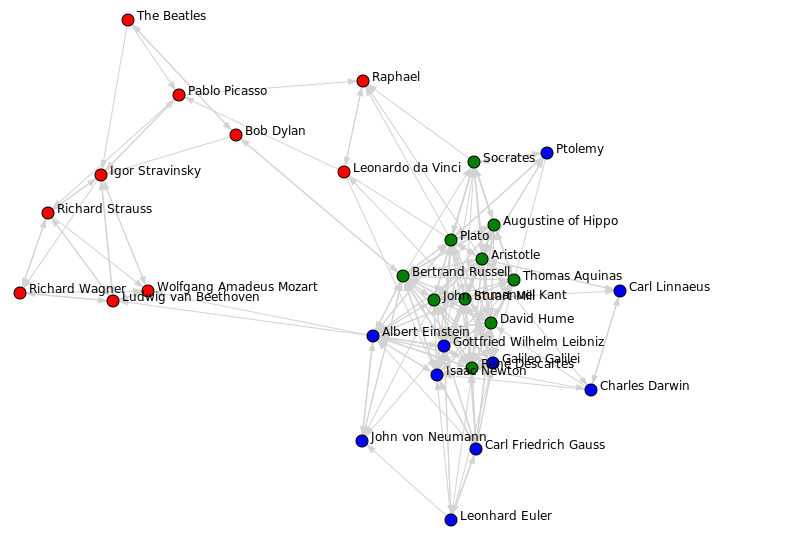

In [3]:
from sknetwork.embedding import Spring, SVD
from sknetwork.visualization import svg_graph, svg_bigraph

## colors = 3 topics (labels)
layout = Spring(position_init='spectral').fit_transform(A)
image = svg_graph(A, names=names, position=layout, width=600, height=500, labels=labels,
                  node_size=6, edge_color='lightgray')
SVG(image)


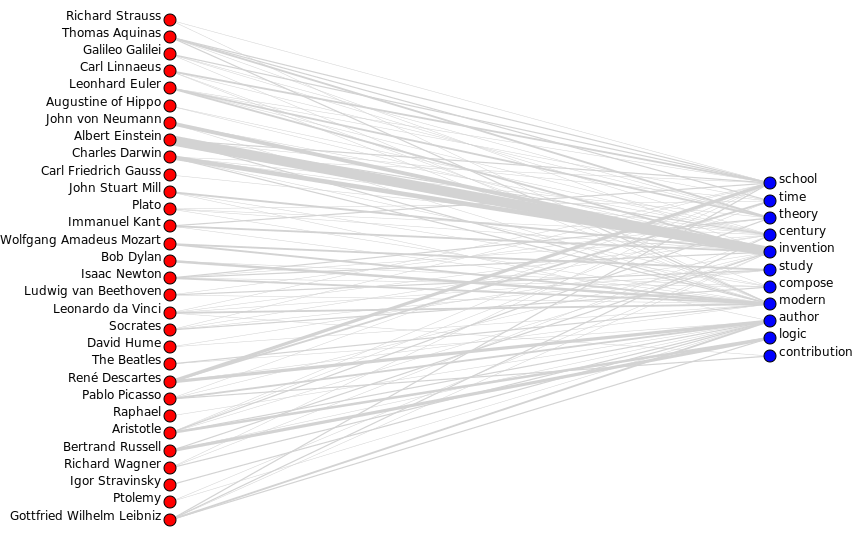

In [4]:
## features (keywords)
image = svg_bigraph(features, names_row=names, names_col=names_features, width=600, height=500, 
                    color_row='red', color_col='blue', node_size=6, edge_color='lightgray')
SVG(image)


## (1) Ego nets and shortest paths

We look at the number of hops in the shortest path, either **from** source node(s) or **to** destination node(s).

We also look at the **undirected** version.

We use ```seed = 'Leonhard Euler'```


In [5]:
from sknetwork.path import get_distances, get_shortest_path
## path length FROM the source
seed = 'Leonhard Euler'
seed_id = np.where(names==seed)[0][0]
distances = get_distances(A, seed_id)
print(Counter(distances))

## which nodes are furthest away
print('furthest nodes:',names[distances == max(distances)])

Counter({2: 11, 3: 7, 1: 6, 4: 5, 0: 1})
furthest nodes: ['Richard Wagner' 'Igor Stravinsky' 'The Beatles' 'Richard Strauss'
 'Pablo Picasso']


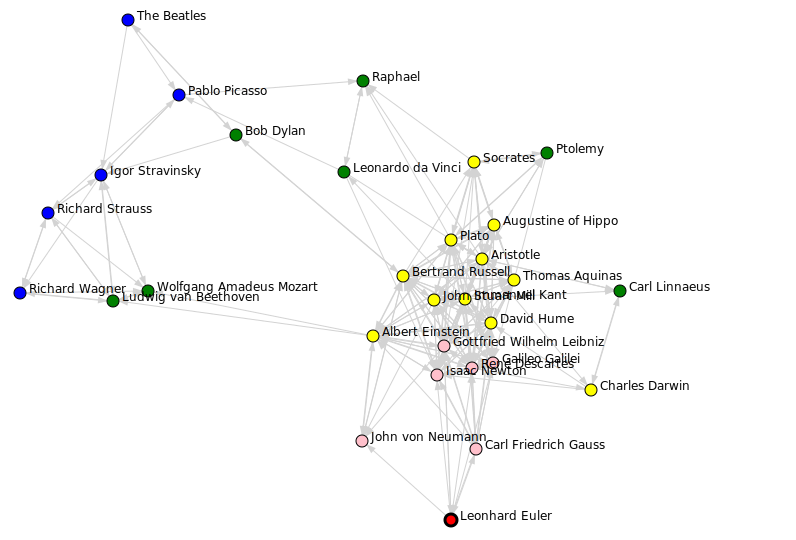

In [6]:
## color w.r.t. distance FROM seed node
image = svg_graph(A, names=names, position=layout, width=600, height=500, seeds=seed_id,
                  labels=distances, node_size=6, node_order = np.argsort(-distances),
                  label_colors=['red','pink','yellow','green','blue'],
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)


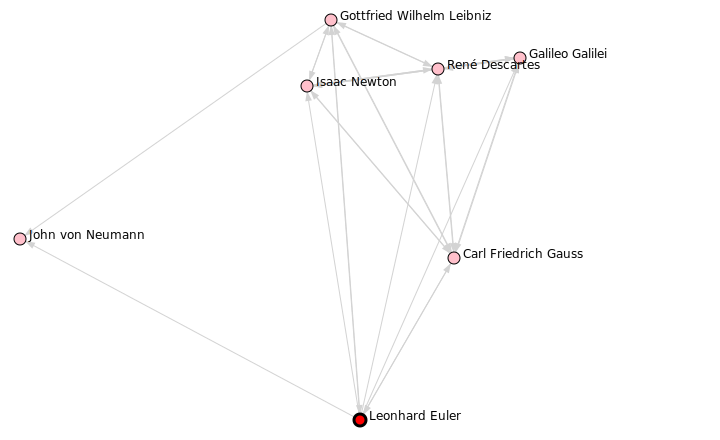

In [7]:
## Subgraph (here, 1-hop ego-net) can be obtained via slicing
hop = np.where(distances<=1)[0]
A_sub = A[hop][:,hop]
seed_id = np.where(names[hop]==seed)[0][0]

image = svg_graph(A_sub, names=names[hop], position=layout[hop], width=500, height=400, seeds=seed_id,
                  labels=distances[hop], node_size=6, node_order = np.argsort(-distances[hop]),
                  label_colors=['red','pink','yellow','green','blue'],
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)


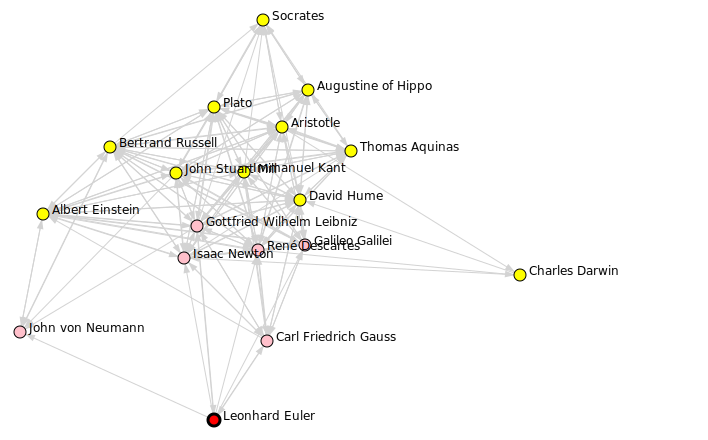

In [8]:
## Subgraph (here, 2-hop ego-net)
hop = np.where(distances<=2)[0]
A_sub = A[hop][:,hop]
seed_id = np.where(names[hop]==seed)[0][0]

image = svg_graph(A_sub, names=names[hop], position=layout[hop], width=500, height=400, seeds=seed_id,
                  labels=distances[hop], node_size=6, node_order = np.argsort(-distances[hop]),
                  label_colors=['red','pink','yellow','green','blue'],
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)


In [9]:
## path length TO the destination
seed_id = np.where(names==seed)[0][0]
distances = get_distances(A.transpose(), seed_id)
print(Counter(distances))

## which nodes are furthest away
print('furthest nodes:',names[distances >= max(distances)-1])


Counter({2: 12, 3: 7, 7: 3, 1: 2, 4: 2, 0: 1, 8: 1, 6: 1, 5: 1})
furthest nodes: ['Richard Wagner' 'Ludwig van Beethoven' 'Wolfgang Amadeus Mozart'
 'Richard Strauss']


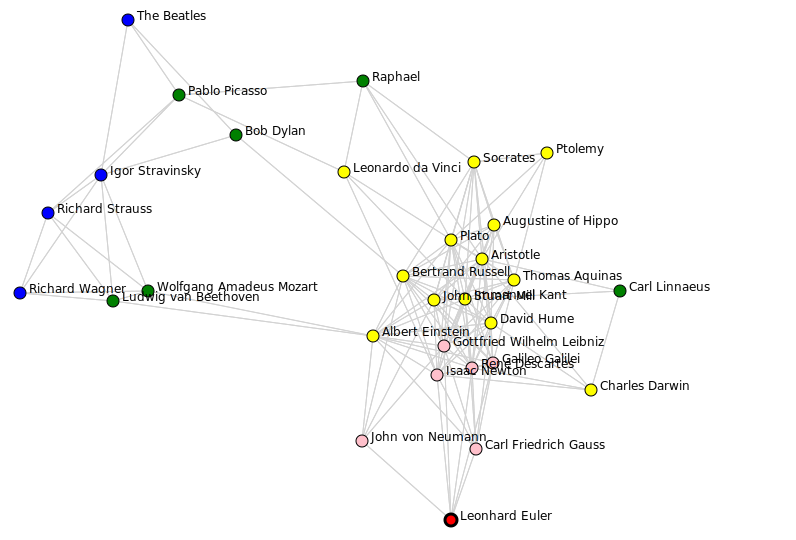

In [10]:
## undirected graph - distance from seed
from sknetwork.utils import directed2undirected
A_und = directed2undirected(A)
seed_id = np.where(names==seed)[0][0]
distances = get_distances(A_und, seed_id)

## color w.r.t. distance 
image = svg_graph(A_und, names=names, position=layout, width=600, height=500, seeds=seed_id,
                  labels=distances, node_size=6, node_order = np.argsort(-distances),
                  label_colors=['red','pink','yellow','green','blue'],
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)


## (2) Clustering and filtering

We consider the undirected version of the toy graph and perform clustering.

Using ```seed = 'Leonhard Euler'```, we look at:
* the cluster containing the seed, and
* the top nodes in that cluster w.r.t. ECG-based score

We use ```igraph``` for the ECG clustering


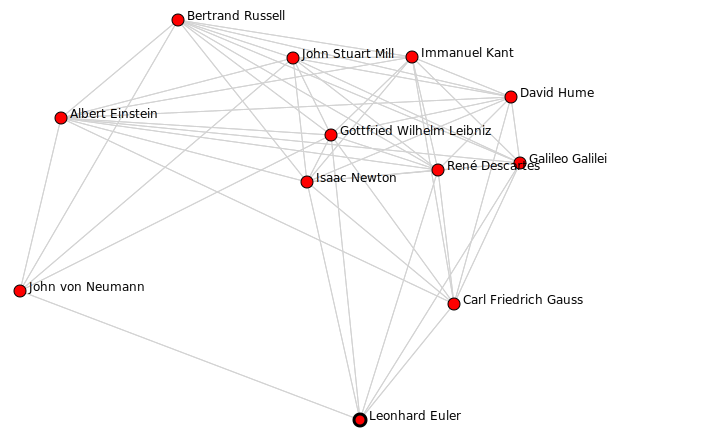

In [11]:
import igraph as ig
import partition_igraph

## igraph graph given adjacency
g = ig.Graph.Adjacency(A_und, 'undirected')

## run ECG
random.seed(321)
np.random.seed(321)
ecg = g.community_ecg(final='leiden', refuse_score=True)
g.vs['ecg'] = ecg.membership
g.vs['name'] = names
g.vs['refuse'] = ecg.refuse_overall ## low value == strong community membership

## find cluster with seed node
seed = 'Leonhard Euler'
seed_id = np.where(names==seed)[0][0]
cluster = np.where(np.array(g.vs['ecg']) == g.vs['ecg'][seed_id])[0]

## cluster subgraph 
A_sub = A_und[cluster][:,cluster]
seed_id = np.where(names[cluster]==seed)[0][0]

## plot the cluster
image = svg_graph(A_sub, names=names[cluster], position=layout[cluster], width=500, height=400, seeds=seed_id,
                  labels=np.array(g.vs['ecg'])[cluster], node_size=6, node_order = np.argsort(-distances[cluster]),
                  label_colors=['red','pink','yellow','green','blue'],
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)

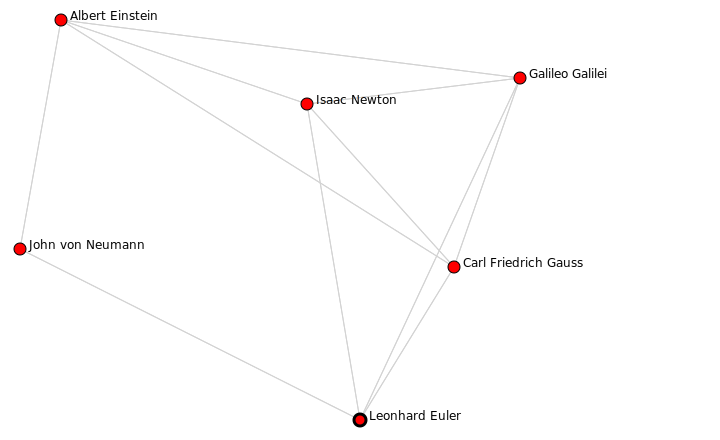

In [12]:
## zoom-in on sub-cluster with strongest in-cluster score (low "refuse to cluster" score) 
sub_cluster = [x for x in cluster if g.vs[x]['refuse']<.3] ## lower threshold = more pruning
A_sub = A_und[sub_cluster][:,sub_cluster]
seed_id = np.where(names[sub_cluster]==seed)[0][0]

## plot the cluster
image = svg_graph(A_sub, names=names[sub_cluster], position=layout[sub_cluster], width=500, height=400, seeds=seed_id,
                  labels=np.array(g.vs['ecg'])[sub_cluster], node_size=6, node_order = np.argsort(-distances[sub_cluster]),
                  label_colors=['red','pink','yellow','green','blue'],
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)


In [13]:
from ipywidgets import interactive
# import ipywidgets as widgets
# from IPython.display import display

def zoomin(th=.3):
    sub_cluster = [x for x in cluster if g.vs[x]['refuse']<=th] ## lower threshold = more pruning
    seed_id = np.where(names[sub_cluster]==seed)[0][0]
    g_sub = g.subgraph(sub_cluster).simplify()
    g_sub.vs['label'] = g_sub.vs['name']
    g_sub.vs['label_color'] = 'red'
    g_sub.vs[seed_id]['label_color'] = 'black'
    fig, ax = plt.subplots()
    ig.plot(g_sub, target=ax, bbox=(0,0,400,300), margin=40, vertex_size=1, vertex_label_size=8, edge_color='lightgray')
    
interactive(zoomin, th=(0.24,0.36,0.005))


interactive(children=(FloatSlider(value=0.3, description='th', max=0.36, min=0.24, step=0.005), Output()), _do…

## (3) Personalized PageRank

In [14]:
## set seed node 
seed = 'Leonhard Euler'
seed_id = np.where(np.array(g.vs['name'])==seed)[0][0]

## store ppr and sort, showing top nodes
## recall 'g' is the igraph Graph object
df = pd.DataFrame()
df['ppr'] = g.personalized_pagerank(reset_vertices=[seed_id]) ## using the igraph PPR implementation
df['name'] = g.vs['name']
df.sort_values(by='ppr', ascending=False).head(8)


,ppr,name
8,0.171144,Leonhard Euler
5,0.080368,Gottfried Wilhelm Leibniz
27,0.064040,René Descartes
0,0.061066,Isaac Newton
6,0.060564,Carl Friedrich Gauss
7,0.053672,Galileo Galilei
20,0.049016,Aristotle
24,0.048855,Immanuel Kant


In [15]:
## now with respect to several seed nodes
seeds = ['Leonhard Euler', 'Leonardo da Vinci']
seeds_id = [np.where(np.array(g.vs['name'])==x)[0][0] for x in seeds]

## store ppr and sort, show top nodes
df = pd.DataFrame()
df['ppr'] = g.personalized_pagerank(reset_vertices=seeds_id)
df['name'] = g.vs['name']
df.sort_values(by='ppr', ascending=False).head(6)


,ppr,name
10,0.092826,Leonardo da Vinci
8,0.090177,Leonhard Euler
20,0.060987,Aristotle
0,0.058472,Isaac Newton
5,0.057852,Gottfried Wilhelm Leibniz
24,0.054426,Immanuel Kant


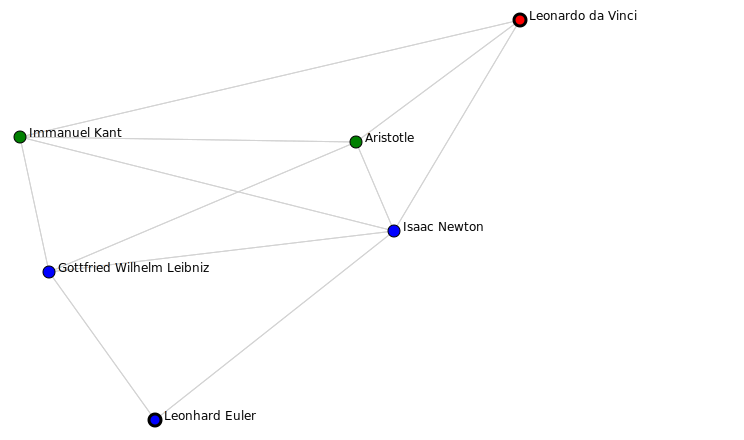

In [16]:
## plot the above top scoring nodes
## colors w.r.t. real labels
sub_cluster = df.sort_values(by='ppr', ascending=False).head(6).index.tolist()
A_sub = A_und[sub_cluster][:,sub_cluster]
seeds_id = np.where([x in set(seeds) for x in names[sub_cluster]])[0]

## plot the cluster
image = svg_graph(A_sub, names=names[sub_cluster], width=500, height=400, seeds=seeds_id,
                  labels=labels[sub_cluster], node_size=6, node_order = np.argsort(-distances[sub_cluster]),
                  edge_color='lightgray', display_edge_weight=False)
SVG(image)


In [17]:
## using scikit-network's PPR implementation
from sknetwork.ranking import PageRank

## now with respect to several seed nodes
seeds = ['Leonhard Euler', 'Leonardo da Vinci']
seeds_id = [np.where(np.array(g.vs['name'])==x)[0][0] for x in seeds]
weights = {}
for s in seeds_id:
    weights[s] = 1

pagerank = PageRank()
pr = pagerank.fit_predict(A_und,weights)

## store ppr and sort, show top nodes
df = pd.DataFrame()
df['ppr'] = pr
df['name'] = g.vs['name']
df.sort_values(by='ppr', ascending=False).head(6)


,ppr,name
10,0.092893,Leonardo da Vinci
8,0.090243,Leonhard Euler
20,0.061318,Aristotle
0,0.058714,Isaac Newton
5,0.058130,Gottfried Wilhelm Leibniz
24,0.054716,Immanuel Kant


## (4) Semi-supervised (transductive) learning 

Given some labelled nodes (both positive and negative labels, typically +1 and -1), rank all other nodes (labelled with 0) as being closer to the positive/negative labelled ones.

Having negative labels is optional.


In [18]:
from scipy.sparse.linalg import cg, inv
from math import sqrt
from scipy.sparse import csr_matrix, diags, identity, rand

## Input: 
##   W: adjacency -- weighted triangular sparse matrix
##   y: initial (seed) values
## Output:
##   x: solution of regularization problem via CG or (slow) explicit matrix inversion
def TLoG_und(W, y, alpha=0.5, inverse=False):
    ## undirected -- make W symmetric
    W = W+W.transpose()
    ## build D^{-1/2}, diagonal
    d = np.array(W.sum(axis=0))[0]
    d = [[1/sqrt(d[i]) for i in range(d.shape[0])]]
    D = diags(d, offsets=[0])
    ## Smothness matrix (here for undirected graph):
    ## S = D^{1/2} * W * D^{-1/2}
    S = D * W * D
    ## M = I - alpha*S
    n = W.shape[0]
    I = identity(n)
    M = I - alpha*S
    if(inverse):
        ## Inverse matrix
        Minv = inv(M)
        x = Minv * y    
    else:
        ## Conj. gradient
        x = cg(M,y)[0]       
    return(x)


In [19]:
## first set all labels to 0
y = np.repeat(0, A_und.shape[0])

names_dict = {v:k for k,v in enumerate(names)}

## label 2 philophers as positive class
y[names_dict['Socrates']] = 1
y[names_dict['Thomas Aquinas']] = 1

## label 2 scientists as negative class
y[names_dict['Galileo Galilei']] = -1
y[names_dict['Leonhard Euler']] = -1


In [20]:
## run and sort results - colors w.r.t. threshold (th) around zero
tl = TLoG_und(A_und, y)
lab = np.argsort(tl)
th = .01
for i in lab:
    if tl[i] > th:
        print("\033[1;31m"+names[i]+' : '+str(tl[i]))
    else:
        if tl[i] < -th:
            print("\033[1;34m"+names[i]+' : '+str(tl[i]))
        else:
            print("\033[1;32m"+names[i]+' : '+str(tl[i]))


Leonhard Euler : -1.0617015887128347
Galileo Galilei : -1.0419070271873128
Carl Friedrich Gauss : -0.157501858617922
John von Neumann : -0.07134978199619968
Isaac Newton : -0.059193646736262054
Albert Einstein : -0.04845505615180202
René Descartes : -0.031430423066572906
Gottfried Wilhelm Leibniz : -0.002763545422156263
Wolfgang Amadeus Mozart : -0.001946970119224663
Ludwig van Beethoven : -0.0017690664727028067
Richard Wagner : -0.00027878060065321294
Richard Strauss : 0.00019936468947421735
Igor Stravinsky : 0.0007354450443507989
Charles Darwin : 0.0008632786987403103
The Beatles : 0.0013482408722419103
Bob Dylan : 0.0028388487416957497
Carl Linnaeus : 0.006224376993370117
Pablo Picasso : 0.0064846439269770914
Leonardo da Vinci : 0.011954106313051906
David Hume : 0.027688229264075236
Immanuel Kant : 0.02789763003811445
Bertrand Russell : 0.02989773590817987
John Stuart Mill : 0.03376263851478216
Raphael : 0.06293665820780836
Aristotle : 0.06306043343215756
Plato : 0.06602633610181571

## (5) Simple GNN 

In [21]:
from scipy.sparse import hstack
from sknetwork.gnn import GNNClassifier as GNN


In [22]:
## first set all labels to -1 (will be ignored for training)
labels_train = np.repeat(-1, A_und.shape[0])

## train using 2 from each class
training_set = ['Socrates','Thomas Aquinas',
                'Galileo Galilei','Leonhard Euler',
                'The Beatles', 'Wolfgang Amadeus Mozart']

for x in training_set:
    labels_train[names_dict[x]] = labels[names_dict[x]] 

Counter(labels_train)

Counter({-1: 24, 0: 2, 1: 2, 2: 2})

In [23]:
hidden_dim = 5
n_labels = 3

## Pick one model:

# simple GCN classifier with a single hidden layer
gnn = GNN(dims=[hidden_dim, n_labels],
                layer_types='Conv',
                activations='ReLu',
                verbose=True)

# GraphSAGE
# gnn = GNN(dims=[hidden_dim, n_labels],
#                 layer_types='Sage',
#                 verbose=True)

print(gnn)

## for node features, we consider the keywords and the adjacency matrix
node_features = hstack((A, features))

## compute probability w.r.t. 3 labels
gnn_pred = gnn.fit_predict_proba(A, node_features, labels=labels_train, 
                           n_epochs=100, random_state=42)

## store results
df = pd.DataFrame()
df['name'] = names
df['label'] = [names_labels[x] for x in labels]
df['science'] = gnn_pred[:,0]
df['arts'] = gnn_pred[:,1]
df['philosophy'] = gnn_pred[:,2]


GNNClassifier(
    Convolution(layer_type: conv, out_channels: 5, activation: ReLu, use_bias: True, normalization: both, self_embeddings: True)
    Convolution(layer_type: conv, out_channels: 3, activation: Cross entropy, use_bias: True, normalization: both, self_embeddings: True)
)
In epoch   0, loss: 1.237, train accuracy: 0.333
In epoch  10, loss: 1.126, train accuracy: 0.333
In epoch  20, loss: 0.617, train accuracy: 1.000
In epoch  30, loss: 0.589, train accuracy: 1.000
In epoch  40, loss: 0.571, train accuracy: 1.000
In epoch  50, loss: 0.566, train accuracy: 1.000
In epoch  60, loss: 0.561, train accuracy: 1.000
In epoch  70, loss: 0.558, train accuracy: 1.000
In epoch  80, loss: 0.557, train accuracy: 1.000
In epoch  90, loss: 0.556, train accuracy: 1.000


In [24]:
## top w.r.t. science
df.sort_values(by='science', ascending=False).head(10)


,name,label,science,arts,philosophy
1,Albert Einstein,science,0.999998,2.320040e-18,0.000002
8,Leonhard Euler,science,0.999974,9.981045e-13,0.000026
9,John von Neumann,science,0.999902,2.629523e-11,0.000098
3,Charles Darwin,science,0.998858,3.435051e-10,0.001142
6,Carl Friedrich Gauss,science,0.998691,1.115546e-10,0.001309
2,Carl Linnaeus,science,0.996125,8.335495e-07,0.003874
27,René Descartes,philosophy,0.989845,1.359587e-10,0.010155
7,Galileo Galilei,science,0.987575,2.251038e-10,0.012425
5,Gottfried Wilhelm Leibniz,science,0.982119,1.218704e-11,0.017881
28,John Stuart Mill,philosophy,0.969840,4.397261e-11,0.030160


In [25]:
## top w.r.t. arts
df.sort_values(by='arts', ascending=False).head(10)


,name,label,science,arts,philosophy
15,The Beatles,arts,0.000055,0.999937,0.000008
16,Wolfgang Amadeus Mozart,arts,0.000091,0.999898,0.000011
13,Bob Dylan,arts,0.000381,0.999587,0.000032
12,Ludwig van Beethoven,arts,0.006926,0.988677,0.004396
14,Igor Stravinsky,arts,0.013123,0.978817,0.008060
17,Richard Strauss,arts,0.019387,0.971769,0.008844
19,Pablo Picasso,arts,0.021867,0.932387,0.045745
11,Richard Wagner,arts,0.080040,0.852206,0.067753
18,Raphael,arts,0.324514,0.081959,0.593528
10,Leonardo da Vinci,arts,0.231993,0.003450,0.764556


In [26]:
## top w.r.t. philosophy
df.sort_values(by='philosophy', ascending=False).head(10)


,name,label,science,arts,philosophy
29,Socrates,philosophy,0.000132,1.104534e-04,0.999758
22,Augustine of Hippo,philosophy,0.000801,9.708433e-08,0.999199
23,Thomas Aquinas,philosophy,0.019891,2.864653e-08,0.980109
21,Plato,philosophy,0.053437,1.373462e-09,0.946563
4,Ptolemy,science,0.062712,2.129016e-04,0.937075
26,David Hume,philosophy,0.232817,9.704194e-10,0.767183
10,Leonardo da Vinci,arts,0.231993,3.450388e-03,0.764556
24,Immanuel Kant,philosophy,0.344933,1.553000e-10,0.655067
18,Raphael,arts,0.324514,8.195866e-02,0.593528
20,Aristotle,philosophy,0.717570,3.938017e-08,0.282430
